In [ ]:
!pip install technical_analysis
# !pip install TA-Lib
!pip install pandas_ta

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

import technical_analysis
import technical_analysis.backtest
import technical_analysis.hurst
import technical_analysis.moving_average
import technical_analysis.indicators
import technical_analysis.utils
import technical_analysis.stats

import pandas_ta

import tensorflow as tf

In [ ]:
df = pd.read_csv('msft_us_d.csv')
df.head()

,Date,Open,High,Low,Close,Volume
0,1986-03-13,0.061571,0.069028,0.061571,0.069028,1.496329e+09
1,1986-03-14,0.069028,0.069028,0.069028,0.069028,4.469023e+08
2,1986-03-17,0.069028,0.069028,0.069028,0.069028,1.931286e+08
3,1986-03-18,0.069028,0.069028,0.069028,0.069028,9.827675e+07
4,1986-03-19,0.069028,0.069028,0.069028,0.069028,6.945781e+07


## Data Preprocessing

In [ ]:
def cleaning(df):
    df = df.copy()
    cols = dict(zip(df.columns, [col.lower() for col in df.columns.to_list()]))
    df.rename(columns=cols, inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    # df = df[df['date'] > '2004-01-01']
    df.reset_index(drop=True, inplace=True)
    return df

df = cleaning(df)

## TI

In [ ]:
def get_scp(df, period=12):
    df = df.copy()
    df[f'shift_{period:02d}'] = df['close'].shift(period)
    df[f'diff_{period:02d}'] = df['close'] - df[f'shift_{period:02d}']
    df[f'scp_{period:02d}'] = np.tanh(df[f'diff_{period:02d}'])
    df.drop(columns=[f'shift_{period:02d}', f'diff_{period:02d}'], inplace=True)
    return df

def get_trend_indicators(df, period):
    open, high, low, close, volume = df['open'], df['high'], df['low'], df['close'], df['volume']

    df[f'dema_{period:02d}'] = pandas_ta.dema(close=close, length=period)
    df[f'ema_{period:02d}'] = pandas_ta.ema(close=close, length=period)
    df[f'fwma_{period:02d}'] = pandas_ta.fwma(close=close, length=period)
    df[f'hma_{period:02d}'] = pandas_ta.hma(close=close, length=period)
    df[f'linreg_{period:02d}'] = pandas_ta.linreg(close=close, length=period)
    df[f'midpoint_{period:02d}'] = pandas_ta.midpoint(close=close, length=period)
    df[f'pwma_{period:02d}'] = pandas_ta.pwma(close=close, length=period)
    df[f'rma_{period:02d}'] = pandas_ta.rma(close=close, length=period)
    df[f'sinwma_{period:02d}'] = pandas_ta.sinwma(close=close, length=period)
    df[f'sma_{period:02d}'] = pandas_ta.sma(close=close, length=period)
    df[f'ssf_{period:02d}'] = pandas_ta.ssf(close=close, length=period)
    df[f'swma_{period:02d}'] = pandas_ta.swma(close=close, length=period)
    df[f't3_{period:02d}'] = pandas_ta.t3(close=close, length=period)
    df[f'tema_{period:02d}'] = pandas_ta.tema(close=close, length=period)
    df[f'trima_{period:02d}'] = pandas_ta.trima(close=close, length=period)
    # df[f'vidya_{period:02d}'] = pandas_ta.vidya(close=close, length=period)
    df[f'wma_{period:02d}'] = pandas_ta.wma(close=close, length=period)

    df[f'doublema_{period:02d}'] = technical_analysis.moving_average.double_ema(price=close, period=period)
    # df[f'ema_{period:02d}'] = technical_analysis.moving_average.ema(price=close, period=period)
    df[f'gma_{period:02d}'] = technical_analysis.moving_average.gma(price=close, period=period)
    # df[f'kama_{period:02d}'] = technical_analysis.moving_average.kama(price=close, period=11, min_smoothing_constant=1, max_smoothing_constant=3)
    df[f'lwma_{period:02d}'] = technical_analysis.moving_average.lwma(price=close, period=period)
    # df[f'nsema_{period:02d}'] = technical_analysis.moving_average.n_smoothed_ema(price=close, period=11, n=1)
    # df[f'tma_{period:02d}'] = technical_analysis.moving_average.tma(price=close, period=period)
    df[f'triplema_{period:02d}'] = technical_analysis.moving_average.triple_ema(price=close, period=period)

    return df

def make_dataset(infile, outfile):
    df = pd.read_csv(infile)
    df = cleaning(df)
    for i in range(4, 21):
        df = get_scp(df, period=i)
        df = get_trend_indicators(df, period=i)
    df.to_csv(outfile, index=False)
    return df

df_msft = make_dataset(infile='msft_us_d.csv', outfile='msft_trend.csv')
df_aapl = make_dataset(infile='aapl_us_d.csv', outfile='aapl_trend.csv')
df_hpq = make_dataset(infile='hpq_us_d.csv', outfile='hpq_trend.csv')

In [ ]:
# import inspect
# functions_list = inspect.getmembers(technical_analysis.moving_average, inspect.isfunction)
# for name, func in functions_list:
#     print(name)

In [ ]:
# def get_momentum_indicators(df, period):
#     df = df.copy()
#     open, high, low, close, volume = df['open'], df['high'], df['low'], df['close'], df['volume']

#     df['rsi'] = technical_analysis.indicators.rsi(price=close, period=11)
#     df['willr'] = technical_analysis.indicators.perc_r(high=high, low=low, close=close, period=11)
#     df['mfi'] = talib.MFI(high=high, low=low, close=close, volume=volume, timeperiod=14)
#     df['macd'] = technical_analysis.indicators.macd(price=close, fast_period=12, slow_period=26, signal_period=9, return_histogram=False)
#     df['adl'] = technical_analysis.indicators.adl(high=high, low=low, close=close, volume=volume)
#     # df['adx'] = technical_analysis.indicators.adx(high=high, low=low, close=close, period=10)
#     # df['adxr'] = technical_analysis.indicators.adx_rating(high=high, low=low, close=close, dx_period=10, period=10)
#     # df['dirin'] = technical_analysis.indicators.directional_indicators(high=high, low=low, close=close, period=10)
#     # df['dirmov'] = technical_analysis.indicators.directional_movement(high=high, low=low, close=close, period=10)
#     df['efrat'] = technical_analysis.indicators.efficiency_ratio(price=close, period=11)
#     df['logret'] = technical_analysis.indicators.log_returns(price=close)
#     df['monflow'] = technical_analysis.indicators.money_flow(high=high, low=low, close=close, volume=volume, period=20)
#     df['monflowvol'] = technical_analysis.indicators.money_flow_volume(high=high, low=low, close=close, volume=volume)
#     df['negdirmov'] = technical_analysis.indicators.negative_directional_movement(low=low)
#     df['onbalvol'] = technical_analysis.indicators.on_balance_volume(price=close, volume=volume)
#     df['percb'] = technical_analysis.indicators.perc_b(price=close, period=20, num_std=2)
#     df['percd'] = technical_analysis.indicators.perc_d(price=close, period=20)
#     df['posdirmov'] = technical_analysis.indicators.positive_directional_movement(high=high)
#     df['rvol'] = technical_analysis.indicators.rvol(volume=volume, period=11)
#     # df['stoch'] = technical_analysis.indicators.stochastic(high=high, low=low, close=close, period=11, perc_k_smoothing=1, perc_d_smoothing=3)
#     df['trix'] = technical_analysis.indicators.trix(price=close, period=15)
#     # df['truedirmov'] = technical_analysis.indicators.true_directional_movement(high=high, low=low, close=close, period=10)
#     df['truerange'] = technical_analysis.indicators.true_range(high=high, low=low, close=close)
#     df['tsi'] = technical_analysis.indicators.tsi(price=close, period1=25, period2=13)
#     df['volatil'] = technical_analysis.indicators.volatility(price=close, period=11, use_log=True)
#     df['wilderma'] = technical_analysis.indicators.wilder_ma(price=close, period=11)
#     df['cmpctch'] = technical_analysis.utils.cum_pct_change(price=close)
#     df['atr'] = technical_analysis.indicators.atr(high=high, low=low, close=close, period=14)

#     return df

# df = get_ti(df)
# df.head()

# CNN


# Preparation

## Library Preparation

In [ ]:
!pip uninstall -y scikit-learn imbalanced-learn
!pip install scikit-learn==1.7.2 imbalanced-learn==0.14.0

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
Found existing installation: imbalanced-learn 0.14.0
Uninstalling imbalanced-learn-0.14.0:
  Successfully uninstalled imbalanced-learn-0.14.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 15.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import imblearn
import tensorflow as tf

from tqdm import tqdm
from collections import Counter
import os

import warnings
warnings.filterwarnings('ignore')

## Directory Preparation

In [ ]:
DATA_DIR = './'
MODEL_DIR = './models/'
LOG_DIR = './logs/'
OUTPUT_DIR = './images/'

for directory in [MODEL_DIR, LOG_DIR, OUTPUT_DIR]:
    if not os.path.exists(directory):
        os.makedirs(directory)

## Data Preparation

In [ ]:
df_msft = pd.read_csv(os.path.join(DATA_DIR, 'msft_trend.csv'))
df_aapl = pd.read_csv(os.path.join(DATA_DIR, 'aapl_trend.csv'))
df_hpq = pd.read_csv(os.path.join(DATA_DIR, 'hpq_trend.csv'))

df_msft.head()

,date,open,high,low,close,volume,scp_04,dema_04,ema_04,fwma_04,...,ssf_20,swma_20,t3_20,tema_20,trima_20,wma_20,doublema_20,gma_20,lwma_20,triplema_20
0,1986-03-13,0.061571,0.069028,0.061571,0.069028,1.496329e+09,NaN,NaN,NaN,NaN,...,0.069028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1986-03-14,0.069028,0.069028,0.069028,0.069028,4.469023e+08,NaN,NaN,NaN,NaN,...,0.069028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1986-03-17,0.069028,0.069028,0.069028,0.069028,1.931286e+08,NaN,NaN,NaN,NaN,...,0.069028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1986-03-18,0.069028,0.069028,0.069028,0.069028,9.827675e+07,NaN,0.069028,0.069028,0.069028,...,0.069028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1986-03-19,0.069028,0.069028,0.069028,0.069028,6.945781e+07,0.0,0.069028,0.069028,0.069028,...,0.069028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def filter_date(df, start_date):
    df['date'] = pd.to_datetime(df['date'])
    df = df[df['date'] >= start_date]
    df.reset_index(drop=True, inplace=True)
    return df

start_date = '2004-01-01'
df_msft = filter_date(df_msft, start_date)
df_aapl = filter_date(df_aapl, start_date)
df_hpq = filter_date(df_hpq, start_date)

df_msft['date'][0]

Timestamp('2004-01-02 00:00:00')

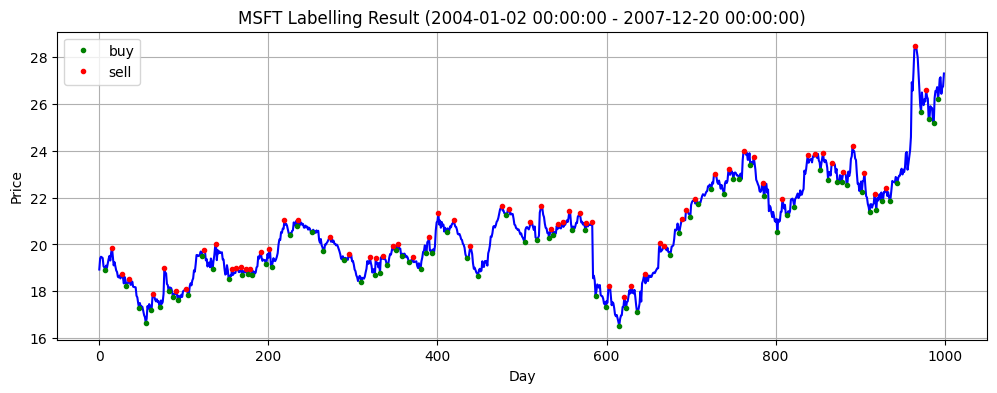

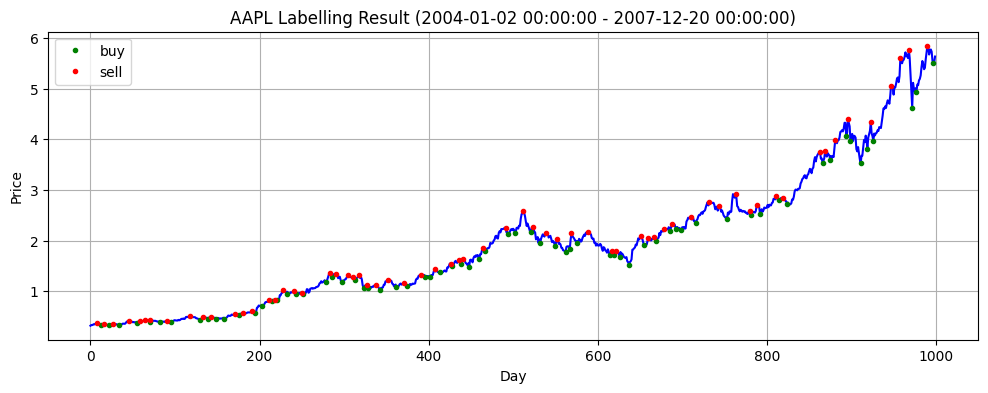

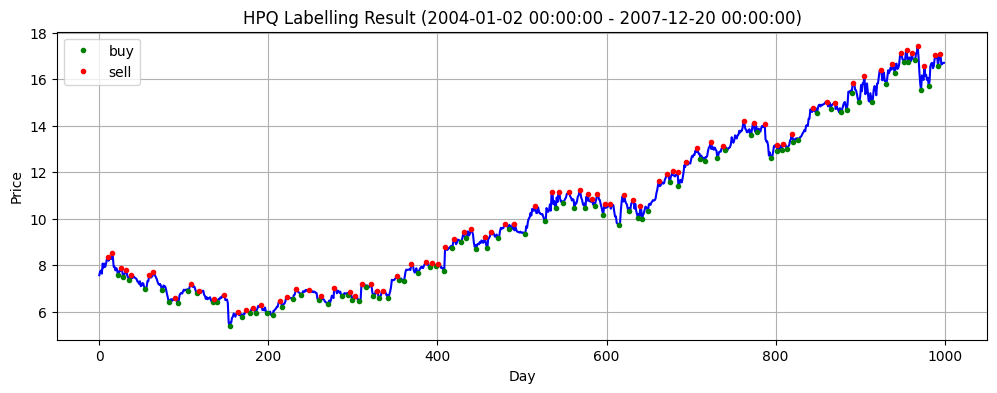

In [ ]:
def labeling(prices, window_size):
    win_begin = 0
    win_end = win_begin + window_size
    pos = 0
    labels = ['hold' for _ in range(len(prices))]
    while pos < len(prices):
        min_val = min(prices[win_begin:win_end])
        max_val = max(prices[win_begin:win_end])
        for i in range(win_begin, win_end):
            if prices[i] == min_val:
                labels[i] = 'buy'
                # labels[i] = 'hold'
            elif prices[i] == max_val:
                labels[i] = 'sell'
                # labels[i] = 'hold'
            else:
                pass
        # win_begin = win_begin + 1
        win_begin = win_end + 1
        win_end = win_begin + window_size
        pos = win_end

    return labels

def sezer_labeling(df, window_size):
    df = df.copy()
    df['label'] = 'hold'
    middle_offset = window_size // 2
    prices = df['close'].values
    n_days = len(prices)
    for i in range(n_days - window_size + 1):
        window = prices[i : i + window_size]
        current_middle_index = i + middle_offset
        local_min_idx = np.argmin(window) # Returns first occurrence of min
        local_max_idx = np.argmax(window) # Returns first occurrence of max
        if local_max_idx == middle_offset:
            df.iloc[current_middle_index, df.columns.get_loc('label')] = 'sell'
        elif local_min_idx == middle_offset:
            df.iloc[current_middle_index, df.columns.get_loc('label')] = 'buy'

    return df

def plot_label(df, title, start, end):
    dates = df['date']
    prices = df['close']
    buys = np.where(df['label'] == 'buy', df['close'], None)
    sells = np.where(df['label'] == 'sell', df['close'], None)
    holds = np.where(df['label'] == 'hold', df['close'], None)
    fig, ax = plt.subplots(figsize=(12, 4))
    # ax.set_facecolor('black')
    margin = 0.05 * (end-start)
    plt.plot(np.array(df['close'][start:end]), '-', color='blue')
    plt.plot(buys[start:end], 'go', markersize=3, label='buy')
    plt.plot(sells[start:end], 'ro', markersize=3, label='sell')
    # plt.hlines(0, xmin=start, xmax=end)
    plt.title(f'{title} Labelling Result ({dates[start]} - {dates[end-1]})')
    plt.legend()
    plt.xlabel("Day")
    plt.ylabel("Price")
    # plt.xticks(range(start, end, 1000))
    plt.xlim([-margin, (end-start) + margin])
    # plt.ylim(0,70)
    plt.grid()
    plt.show()

window_size = 9
df_msft = sezer_labeling(df_msft, window_size=window_size)
df_aapl = sezer_labeling(df_aapl, window_size=window_size)
df_hpq = sezer_labeling(df_hpq, window_size=window_size)

start, end = 0, 1000
plot_label(df_msft, 'MSFT', start, end)
plot_label(df_aapl, 'AAPL', start, end)
plot_label(df_hpq, 'HPQ', start, end)

In [ ]:
df_msft['label'].value_counts(), df_aapl['label'].value_counts(), df_hpq['label'].value_counts()

(label
 hold    4684
 buy      418
 sell     414
 Name: count, dtype: int64,
 label
 hold    4774
 buy      378
 sell     364
 Name: count, dtype: int64,
 label
 hold    4651
 buy      435
 sell     430
 Name: count, dtype: int64)

In [ ]:
cols_with_nan = df_msft.columns[df_msft.isna().any()].tolist()
print(cols_with_nan)

[]


# Model Building

## Preparation

In [ ]:
# def scaling(df, cols):
#     df = df.copy()
#     scaler = MinMaxScaler()
#     df[cols] = scaler.fit_transform(df[cols])
#     return df

# def create_X_y_ts(df, cols, dt):
#     start_id = np.argmax(np.array(~pd.isna(df[cols].T).any()))
#     X = [df[cols].loc[i:i+(dt-1)].values for i in range(start_id, len(df)-(dt-1))]
#     X = np.array(X)
#     X_shape = X.shape
#     X = X.reshape((X_shape[0], X_shape[1], X_shape[2], 1))
#     y = df['label'].loc[start_id+(dt-1):].values
#     return X, y

# def create_X_y_ts_vec(df, cols, dt):
#     data = df[cols].values
#     labels = df['label'].values
#     is_valid_row = ~np.isnan(data).any(axis=1)
#     start_id = np.argmax(is_valid_row)
#     data = data[start_id:]
#     labels = labels[start_id:]
#     windows = numpy.lib.stride_tricks.sliding_window_view(data, window_shape=dt, axis=0)
#     X = windows.transpose(0, 2, 1)
#     X = X[..., np.newaxis]
#     y = labels[dt-1:]
#     return X, y

def create_X_y(df):
    ori_cols = ['date', 'open', 'high', 'low', 'close', 'volume', 'label']
    cols = [col for col in df.columns if col not in ori_cols]
    tis = np.unique([col.split('_')[0] for col in cols])
    start_id = np.argmax(np.array(~pd.isna(df[cols].T).any()))
    X = np.array(df[cols][start_id:].values)
    y = df['label'][start_id:].values

    return X, y, cols, tis

def encode_category(x, order):
    return order.index(x)

def reshape_X(X, cols, tis):
    width = int(len(cols) / len(tis))
    height = len(tis)
    return np.array([X[i].reshape((width, height, 1)) for i in range(X.shape[0])])

def plot_img(images, labels, classes):
    n = images.shape[0]
    fig, ax = plt.subplots(1, n, figsize=(10, 3))
    for i in range(n):
        img = images[i]
        label = labels[i]
        label = classes[np.argmax(label)]
        ax[i].imshow(img, interpolation='nearest', cmap='gray')
        ax[i].set_title(label, fontsize=9)
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()

def get_sample_weight(y):
    y = np.argmax(y, axis=1)
    classes = np.unique(y)
    class_weights_dict = compute_class_weight(
        class_weight='balanced',
        classes=classes,
        y=y
    )
    class_weights_dict = dict(zip(classes, class_weights_dict))
    sample_weights = np.array([class_weights_dict[label] for label in y])
    return sample_weights

def create_model(name):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
        # tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
        # tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        # tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(units=128, activation='relu'),
        tf.keras.layers.Dense(units=3, activation='softmax')
    ])

    callbacks = [
        # tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,
        #                                 patience=20, min_delta=0.00001),
        # checkpoint_path = (path + 'checkpoint')

        # tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, mode='min', verbose=1,
        #                     min_delta=0.001, min_lr=0.0001),

        tf.keras.callbacks.ModelCheckpoint(os.path.join(MODEL_DIR, f'best_model_{name}.keras'),
                                           save_best_only=True, save_weights_only=False,
                                           monitor='val_loss', mode='min', verbose=1),

        tf.keras.callbacks.CSVLogger(os.path.join(LOG_DIR, f'training_log_{name}.csv'))
    ]

    metrics = [
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(thresholds=0.5, name='precision'),
        tf.keras.metrics.Recall(thresholds=0.5, name='recall'),
        tf.keras.metrics.F1Score(average=None, threshold=0.5, name='f1'),
        tf.keras.metrics.F1Score(average='macro', threshold=0.5, name='f1_macro'),
        tf.keras.metrics.F1Score(average='micro', threshold=0.5, name='f1_micro'),
        tf.keras.metrics.F1Score(average='weighted', threshold=0.5, name='f1_weighted'),
        tf.keras.metrics.AUC(name='auc')
    ]

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=metrics)

    return model, callbacks

def data_pipeline(df):
    # dt = 25
    # df = scaling(df, cols)

    classes = ['buy', 'hold', 'sell']

    X, y, cols, tis = create_X_y(df_msft)

    y = np.array([encode_category(x, classes) for x in y])
    y_oh = tf.keras.utils.to_categorical(y)

    print(f'X: {X.shape}')
    print(f'y: {y.shape}, {y_oh.shape}')

    cc = imblearn.under_sampling.ClusterCentroids()
    X_res, y_res = cc.fit_resample(X, y)

    # X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, train_size=0.8, shuffle=False)
    # X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, shuffle=False)

    X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, train_size=0.8, shuffle=True, stratify=y_res)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, shuffle=True, stratify=y_val)

    # cc = imblearn.under_sampling.ClusterCentroids()
    # X_train, y_train = cc.fit_resample(X_train, y_train)
    # X_val, y_val = cc.fit_resample(X_val, y_val)
    # X_test, y_test = cc.fit_resample(X_test, y_test)

    # robust_scaler = RobustScaler()
    # X_train = robust_scaler.fit_transform(X_train)
    # X_val = robust_scaler.transform(X_val)
    # X_test = robust_scaler.transform(X_test)

    min_max_scaler = MinMaxScaler(feature_range=(0, 1))
    X_train = min_max_scaler.fit_transform(X_train)
    X_val = min_max_scaler.transform(X_val)
    X_test = min_max_scaler.transform(X_test)

    y_train_oh = tf.keras.utils.to_categorical(y_train)
    y_val_oh = tf.keras.utils.to_categorical(y_val)
    y_test_oh = tf.keras.utils.to_categorical(y_test)

    X_train = reshape_X(X_train, cols, tis)
    X_val = reshape_X(X_val, cols, tis)
    X_test = reshape_X(X_test, cols, tis)

    print(f'Train: {X_train.shape}, {y_train.shape}')
    print(f'Val: {X_val.shape}, {y_val.shape}')
    print(f'Test: {X_test.shape}, {y_test.shape}')

    return X_train, X_val, X_test, y_train, y_val, y_test, y_train_oh, y_val_oh, y_test_oh

def plot_confusion_matrix(cm, class_names, title, filename):
    plt.figure(figsize=(3, 2.5))
    p = sns.heatmap(cm, annot=True, fmt='d', annot_kws={'fontweight':'bold'}, cmap='cool',
                    xticklabels=class_names, yticklabels=class_names)
    p.set_xticklabels(p.get_xticklabels(), rotation=0, fontsize=9)
    p.set_yticklabels(p.get_yticklabels(), rotation=0, fontsize=9)
    plt.xlabel('Predicted Class', fontweight='bold', fontsize=9)
    plt.ylabel('Actual Class', fontweight='bold', fontsize=9)
    plt.title(title, fontweight='bold', fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f'{filename}.png'))
    plt.show()

def dual_plot_training_log(suptitle, filename, train_arr1, val_arr1, title1, train_arr2, val_arr2, title2):
    max_value1 = max(max(train_arr1), max(val_arr1))
    max_value2 = max(max(train_arr2), max(val_arr2))

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax = ax.flatten()

    fig.suptitle(suptitle, fontweight='bold', fontsize=14)

    ax[0].plot(train_arr1, label='Train')
    ax[0].plot(val_arr1, label='Validation')
    ax[0].legend()
    ax[0].set_title(title1)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Value')
    ax[0].set_xlim([-0.02*len(train_arr1), 1.02*len(train_arr1)])
    ax[0].set_ylim([-0.02*max_value1, 1.02*max_value1])
    ax[0].grid(linestyle='--')

    ax[1].plot(train_arr2, label='Train')
    ax[1].plot(val_arr2, label='Validation')
    ax[1].legend()
    ax[1].set_title(title2)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Value')
    ax[1].set_xlim([-0.02*len(train_arr2), 1.02*len(train_arr2)])
    ax[1].set_ylim([-0.02*max_value2, max(1.02, 1.02*max_value2)])
    ax[1].grid(linestyle='--')

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f'{filename}.png'))
    plt.show()

def get_class_distribution_data(y_data, name, class_names=None):
    if y_data.size == 0:
        print(f'\n--- {name} class distribution ---')
        print('  (No samples in this set)')
        return pd.DataFrame(columns=['Dataset', 'Class ID', 'Class Name', 'Count', 'Percentage'])

    if y_data.ndim > 1 and y_data.shape[1] > 1:
        y_integer_labels = np.argmax(y_data, axis=-1)
    else:
        y_integer_labels = np.squeeze(y_data)

    unique_classes, counts = np.unique(y_integer_labels, return_counts=True)
    total_samples = len(y_integer_labels)

    data = []
    for i, c_id in enumerate(unique_classes):
        c_id = int(c_id)
        percentage = (counts[i] / total_samples) * 100
        class_label = class_names[c_id] if class_names and c_id < len(class_names) else f'class_{c_id}'
        data.append({
            'data_subset': name,
            'class_id': c_id,
            'class_name': class_label,
            'count': counts[i],
            'percentage': round(percentage, 4)
        })

    return data

def plot_training_log(train_arr, val_arr, title, filename):
    max_value = max(max(train_arr), max(val_arr))
    plt.figure(figsize=(7, 4.375))
    plt.plot(range(1, len(train_arr)+1), train_arr, '.-', label='Train')
    plt.plot(range(1, len(val_arr)+1), val_arr, '.-', label='Validation')
    plt.legend()
    plt.title(title, fontsize=12, fontweight='bold')
    plt.xlabel('Epoch', fontweight='bold')
    plt.ylabel('Value', fontweight='bold')
    plt.xlim([-0.02*len(train_arr), 1.02*len(train_arr)])
    plt.ylim([-0.02*max_value, 1.02*max_value])
    plt.tight_layout()
    plt.grid()
    plt.savefig(os.path.join(OUTPUT_DIR, f'{filename}.png'))
    plt.show()

classes = ['buy', 'hold', 'sell']

## MSFT

X: (5516, 357)
y: (5516,), (5516, 3)
Train: (993, 17, 21, 1), (993,)
Val: (124, 17, 21, 1), (124,)
Test: (125, 17, 21, 1), (125,)


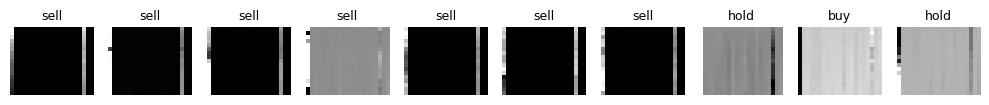

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 17, 21, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 9, 11, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3168)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       405,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 406,339 (1.55 MB)

 Trainable params: 406,339 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, y_train_oh, y_val_oh, y_test_oh = data_pipeline(df_msft)

dist = []
train_dist = get_class_distribution_data(y_train_oh, 'train', classes)
val_dist = get_class_distribution_data(y_val_oh, 'validation', classes)
test_dist = get_class_distribution_data(y_test_oh, 'test', classes)
dist.extend(train_dist)
dist.extend(val_dist)
dist.extend(test_dist)
dist = pd.DataFrame(dist)
out_file = os.path.join(LOG_DIR, f'class_dist_msft.csv')
dist.to_csv(out_file, index=False)

images = X_train[:10]
labels = y_train_oh[:10]
plot_img(images, labels, classes)
sample_weight = get_sample_weight(y_train_oh)

model, callbacks = create_model(name='msft')
model.summary()

In [ ]:
history = model.fit(X_train, y_train_oh, batch_size=16, epochs=100,
                    verbose=1, callbacks=callbacks,
                    validation_data=(X_val, y_val_oh),
                    shuffle=False, sample_weight=sample_weight)

Epoch 1/100
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4962 - auc: 0.6893 - f1: 0.1667 - f1_macro: 0.1667 - f1_micro: 0.2285 - f1_weighted: 0.1649 - loss: 1.0192 - precision: 0.6156 - recall: 0.1441
Epoch 1: val_loss improved from inf to 0.91678, saving model to ./models/best_model_msft.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.4966 - auc: 0.6901 - f1: 0.1693 - f1_macro: 0.1693 - f1_micro: 0.2320 - f1_weighted: 0.1676 - loss: 1.0181 - precision: 0.6168 - recall: 0.1465 - val_accuracy: 0.6371 - val_auc: 0.8215 - val_f1: 0.2812 - val_f1_macro: 0.2812 - val_f1_micro: 0.3067 - val_f1_weighted: 0.2824 - val_loss: 0.9168 - val_precision: 0.8846 - val_recall: 0.1855
Epoch 2/100
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5911 - auc: 0.7762 - f1: 0.3197 - f1_macro: 0.3197 - f1_micro: 0.3776 - f1_weighted: 0.3193 - loss: 0.9292 - precision: 0.7469 - recall: 0.2583
Epoch 2: val_loss improved from 0.91678 to 0.86024, saving model to ./models/best_model_msft.

In [ ]:
log_path = os.path.join(LOG_DIR, 'training_log_msft.csv')
history = pd.read_csv(log_path)
# history.tail()

model_path = os.path.join(MODEL_DIR, 'best_model_msft.keras')
model = tf.keras.models.load_model(model_path)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 17, 21, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 9, 11, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3168)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       405,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,219,019 (4.65 MB)

 Trainable params: 406,339 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 812,680 (3.10 MB)

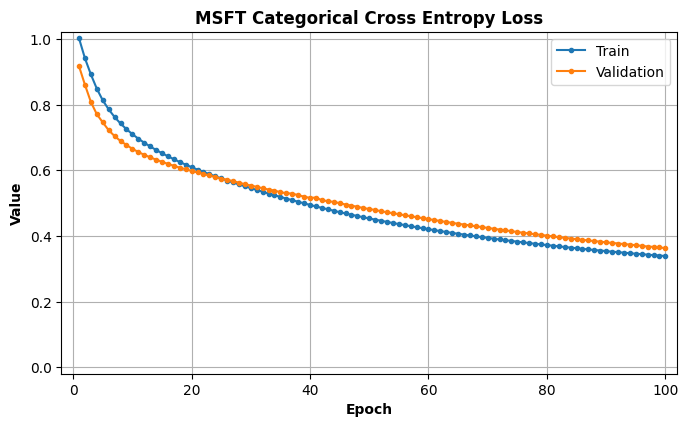

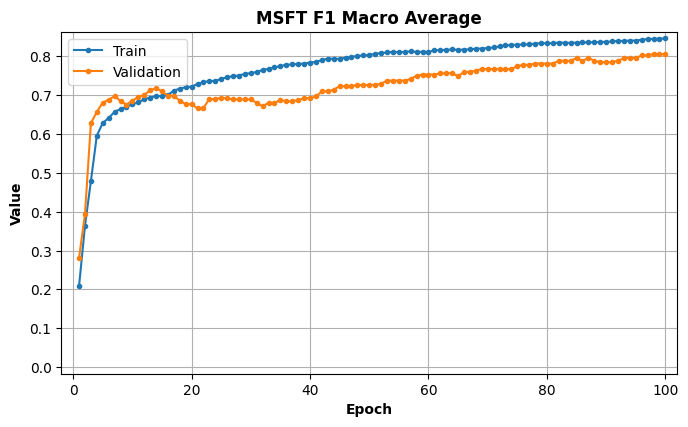

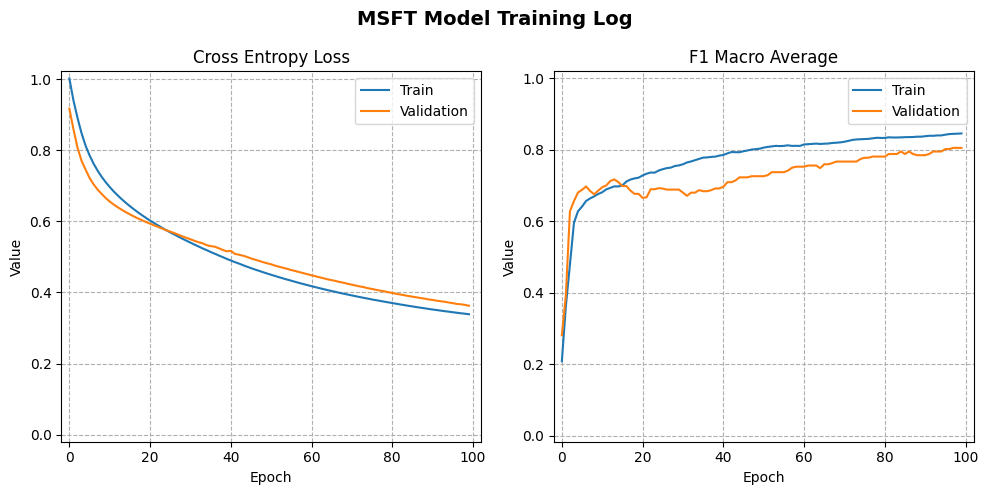

In [ ]:
plot_training_log(history['loss'], history['val_loss'], 'MSFT Categorical Cross Entropy Loss', 'loss_msft')
plot_training_log(history['f1_macro'], history['val_f1_macro'], 'MSFT F1 Macro Average', 'f1_msft')
dual_plot_training_log('MSFT Model Training Log', 'log_msft',
                       history['loss'], history['val_loss'], 'Cross Entropy Loss',
                       history['f1_macro'], history['val_f1_macro'], 'F1 Macro Average')

In [ ]:
# def plot_training_log(history):
#     fig, ax = plt.subplots(figsize=(12, 4))
#     ax.plot(history.history['loss'], label='loss')
#     ax.plot(history.history['val_loss'], label='val_loss')
#     ax.plot(history.history['accuracy'], label='accuracy')
#     ax.plot(history.history['val_accuracy'], label='val_accuracy')
#     ax.plot(history.history['f1'], label='f1')
#     ax.plot(history.history['val_f1'], label='val_f1')
#     ax.legend()
#     ax.grid()
#     plt.show()

# plot_training_log(history)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[[305  24   2]
 [ 35 214  82]
 [  1  16 314]]
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       331
           1       0.84      0.65      0.73       331
           2       0.79      0.95      0.86       331

    accuracy                           0.84       993
   macro avg       0.84      0.84      0.83       993
weighted avg       0.84      0.84      0.83       993



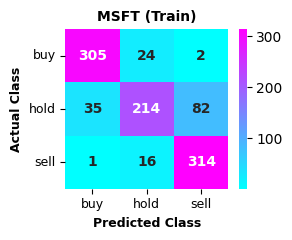

[[39  1  1]
 [ 7 23 12]
 [ 0  1 40]]
              precision    recall  f1-score   support

           0       0.85      0.95      0.90        41
           1       0.92      0.55      0.69        42
           2       0.75      0.98      0.85        41

    accuracy                           0.82       124
   macro avg       0.84      0.82      0.81       124
weighted avg       0.84      0.82      0.81       124



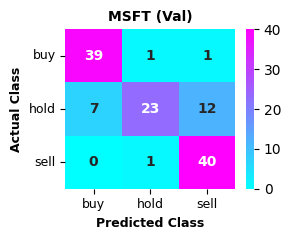

[[37  5  0]
 [ 7 26  8]
 [ 0  2 40]]
              precision    recall  f1-score   support

           0       0.84      0.88      0.86        42
           1       0.79      0.63      0.70        41
           2       0.83      0.95      0.89        42

    accuracy                           0.82       125
   macro avg       0.82      0.82      0.82       125
weighted avg       0.82      0.82      0.82       125



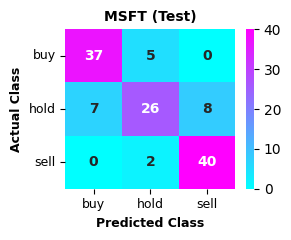

In [ ]:
y_train_pred_prob = model.predict(X_train, verbose=1)
y_train_pred = np.argmax(y_train_pred_prob, axis=1)
y_val_pred_prob = model.predict(X_val, verbose=1)
y_val_pred = np.argmax(y_val_pred_prob, axis=1)
y_test_pred_prob = model.predict(X_test, verbose=1)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)

cm_train = confusion_matrix(y_train, y_train_pred)
cm_val = confusion_matrix(y_val, y_val_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))
plot_confusion_matrix(cm_train, classes, 'MSFT (Train)', 'cm_msft_train')
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))
plot_confusion_matrix(cm_val, classes, 'MSFT (Val)', 'cm_msft_val')
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
plot_confusion_matrix(cm_test, classes, 'MSFT (Test)', 'cm_msft_test')

## AAPL

X: (5516, 357)
y: (5516,), (5516, 3)
Train: (993, 17, 21, 1), (993,)
Val: (124, 17, 21, 1), (124,)
Test: (125, 17, 21, 1), (125,)


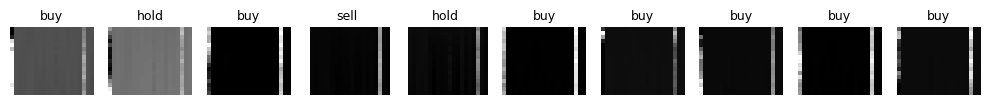

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 17, 21, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 9, 11, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3168)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       405,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 406,339 (1.55 MB)

 Trainable params: 406,339 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, y_train_oh, y_val_oh, y_test_oh = data_pipeline(df_aapl)

dist = []
train_dist = get_class_distribution_data(y_train_oh, 'train', classes)
val_dist = get_class_distribution_data(y_val_oh, 'validation', classes)
test_dist = get_class_distribution_data(y_test_oh, 'test', classes)
dist.extend(train_dist)
dist.extend(val_dist)
dist.extend(test_dist)
dist = pd.DataFrame(dist)
out_file = os.path.join(LOG_DIR, f'class_dist_aapl.csv')
dist.to_csv(out_file, index=False)

classes = ['buy', 'hold', 'sell']
images = X_train[:10]
labels = y_train_oh[:10]
plot_img(images, labels, classes)
sample_weight = get_sample_weight(y_train_oh)

model, callbacks = create_model(name='aapl')
model.summary()

In [ ]:
history = model.fit(X_train, y_train_oh, batch_size=16, epochs=100,
                    verbose=1, callbacks=callbacks,
                    validation_data=(X_val, y_val_oh),
                    shuffle=False, sample_weight=sample_weight)

Epoch 1/100
59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5177 - auc: 0.6971 - f1: 0.1749 - f1_macro: 0.1749 - f1_micro: 0.2312 - f1_weighted: 0.1808 - loss: 1.0132 - precision: 0.5631 - recall: 0.1482
Epoch 1: val_loss improved from inf to 0.92233, saving model to ./models/best_model_aapl.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5174 - auc: 0.6991 - f1: 0.1840 - f1_macro: 0.1840 - f1_micro: 0.2409 - f1_weighted: 0.1895 - loss: 1.0108 - precision: 0.5711 - recall: 0.1555 - val_accuracy: 0.5565 - val_auc: 0.7692 - val_f1: 0.4223 - val_f1_macro: 0.4223 - val_f1_micro: 0.4946 - val_f1_weighted: 0.4240 - val_loss: 0.9223 - val_precision: 0.7419 - val_recall: 0.3710
Epoch 2/100
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5944 - auc: 0.7679 - f1: 0.4246 - f1_macro: 0.4246 - f1_micro: 0.5071 - f1_weighted: 0.4352 - loss: 0.9163 - precision: 0.7279 - recall: 0.3912
Epoch 2: val_loss improved from 0.92233 to 0.86787, saving model to ./models/best_model_aapl.

In [ ]:
log_path = os.path.join(LOG_DIR, 'training_log_aapl.csv')
history = pd.read_csv(log_path)
# history.tail()

model_path = os.path.join(MODEL_DIR, 'best_model_aapl.keras')
model = tf.keras.models.load_model(model_path)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 17, 21, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 9, 11, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3168)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       405,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,219,019 (4.65 MB)

 Trainable params: 406,339 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 812,680 (3.10 MB)

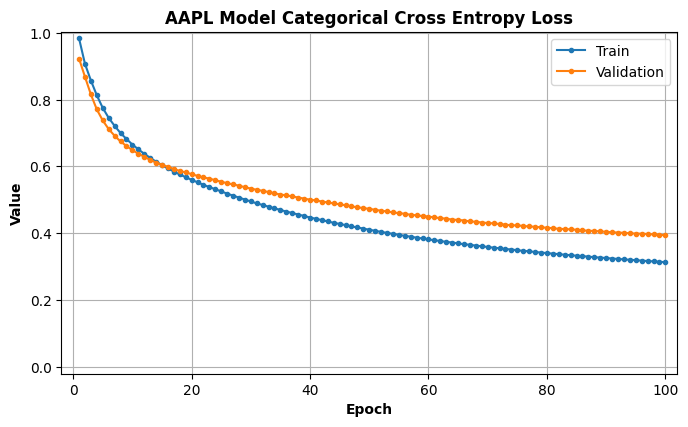

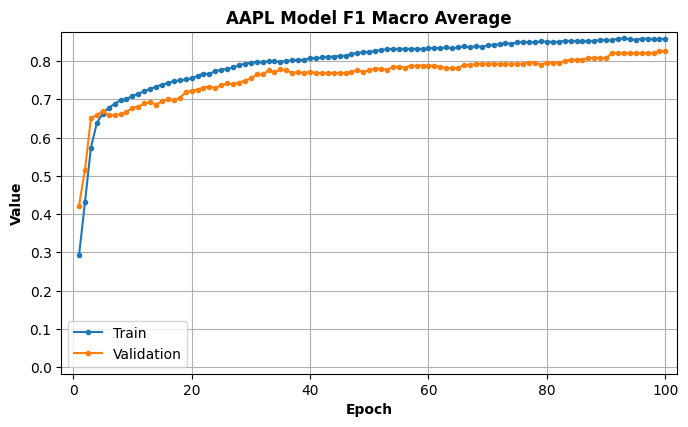

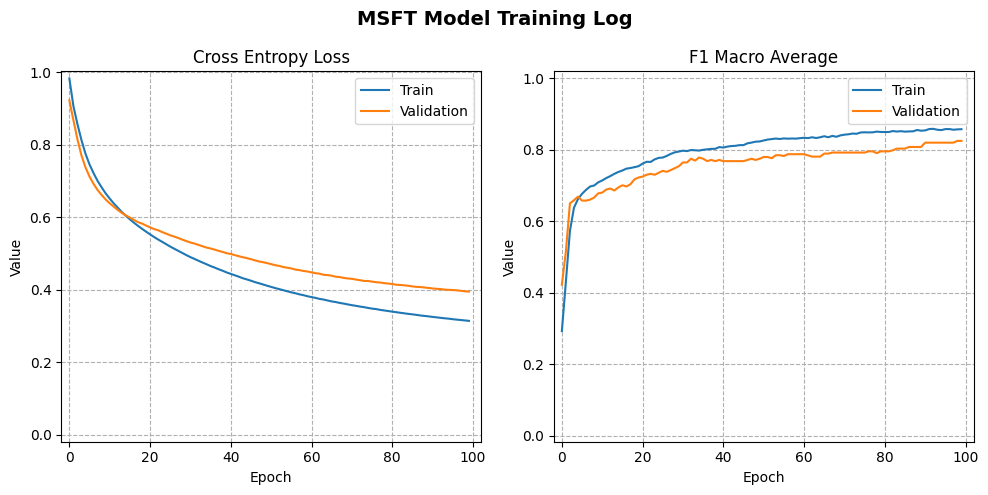

In [ ]:
plot_training_log(history['loss'], history['val_loss'], 'AAPL Model Categorical Cross Entropy Loss', 'loss_aapl')
plot_training_log(history['f1_macro'], history['val_f1_macro'], 'AAPL Model F1 Macro Average', 'f1_aapl')
dual_plot_training_log('MSFT Model Training Log', 'log_aapl',
                       history['loss'], history['val_loss'], 'Cross Entropy Loss',
                       history['f1_macro'], history['val_f1_macro'], 'F1 Macro Average')

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[[298  32   1]
 [ 23 280  28]
 [  3  47 281]]
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       331
           1       0.78      0.85      0.81       331
           2       0.91      0.85      0.88       331

    accuracy                           0.87       993
   macro avg       0.87      0.87      0.87       993
weighted avg       0.87      0.87      0.87       993



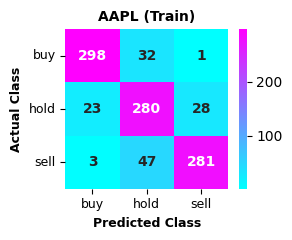

[[36  4  1]
 [ 3 34  4]
 [ 1  7 34]]
              precision    recall  f1-score   support

           0       0.90      0.88      0.89        41
           1       0.76      0.83      0.79        41
           2       0.87      0.81      0.84        42

    accuracy                           0.84       124
   macro avg       0.84      0.84      0.84       124
weighted avg       0.84      0.84      0.84       124



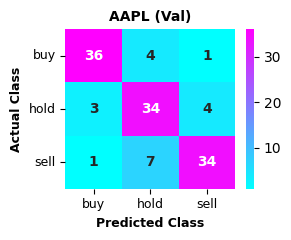

[[39  3  0]
 [ 3 28 11]
 [ 0  5 36]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        42
           1       0.78      0.67      0.72        42
           2       0.77      0.88      0.82        41

    accuracy                           0.82       125
   macro avg       0.82      0.82      0.82       125
weighted avg       0.82      0.82      0.82       125



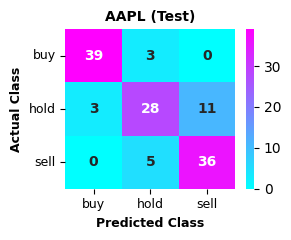

In [ ]:
y_train_pred_prob = model.predict(X_train, verbose=1)
y_train_pred = np.argmax(y_train_pred_prob, axis=1)
y_val_pred_prob = model.predict(X_val, verbose=1)
y_val_pred = np.argmax(y_val_pred_prob, axis=1)
y_test_pred_prob = model.predict(X_test, verbose=1)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)

cm_train = confusion_matrix(y_train, y_train_pred)
cm_val = confusion_matrix(y_val, y_val_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))
plot_confusion_matrix(cm_train, classes, 'AAPL (Train)', 'cm_aapl_train')
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))
plot_confusion_matrix(cm_val, classes, 'AAPL (Val)', 'cm_aapl_val')
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
plot_confusion_matrix(cm_test, classes, 'AAPL (Test)', 'cm_aapl_test')

## HPQ

X: (5516, 357)
y: (5516,), (5516, 3)
Train: (993, 17, 21, 1), (993,)
Val: (124, 17, 21, 1), (124,)
Test: (125, 17, 21, 1), (125,)


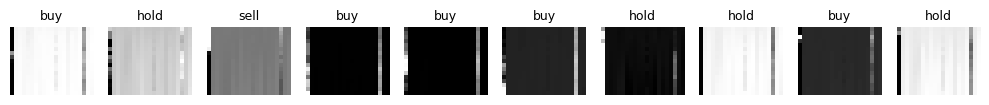

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 17, 21, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 11, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3168)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       405,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 406,339 (1.55 MB)

 Trainable params: 406,339 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, y_train_oh, y_val_oh, y_test_oh = data_pipeline(df_hpq)

dist = []
train_dist = get_class_distribution_data(y_train_oh, 'train', classes)
val_dist = get_class_distribution_data(y_val_oh, 'validation', classes)
test_dist = get_class_distribution_data(y_test_oh, 'test', classes)
dist.extend(train_dist)
dist.extend(val_dist)
dist.extend(test_dist)
dist = pd.DataFrame(dist)
out_file = os.path.join(LOG_DIR, f'class_dist_hpq.csv')
dist.to_csv(out_file, index=False)

classes = ['buy', 'hold', 'sell']
images = X_train[:10]
labels = y_train_oh[:10]
plot_img(images, labels, classes)
sample_weight = get_sample_weight(y_train_oh)

model, callbacks = create_model(name='hpq')
model.summary()

In [ ]:
history = model.fit(X_train, y_train_oh, batch_size=16, epochs=100,
                    verbose=1, callbacks=callbacks,
                    validation_data=(X_val, y_val_oh),
                    shuffle=False, sample_weight=sample_weight)

Epoch 1/100
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5269 - auc: 0.6792 - f1: 0.1570 - f1_macro: 0.1570 - f1_micro: 0.2107 - f1_weighted: 0.1526 - loss: 1.0297 - precision: 0.6554 - recall: 0.1302
Epoch 1: val_loss improved from inf to 0.91259, saving model to ./models/best_model_hpq.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.5271 - auc: 0.6802 - f1: 0.1581 - f1_macro: 0.1581 - f1_micro: 0.2125 - f1_weighted: 0.1538 - loss: 1.0288 - precision: 0.6548 - recall: 0.1315 - val_accuracy: 0.5968 - val_auc: 0.7929 - val_f1: 0.2358 - val_f1_macro: 0.2358 - val_f1_micro: 0.3537 - val_f1_weighted: 0.2396 - val_loss: 0.9126 - val_precision: 0.7250 - val_recall: 0.2339
Epoch 2/100
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5759 - auc: 0.7552 - f1: 0.2817 - f1_macro: 0.2817 - f1_micro: 0.3463 - f1_weighted: 0.2735 - loss: 0.9440 - precision: 0.6794 - recall: 0.2342
Epoch 2: val_loss improved from 0.91259 to 0.84558, saving model to ./models/best_model_hpq.ke

In [ ]:
log_path = os.path.join(LOG_DIR, 'training_log_hpq.csv')
history = pd.read_csv(log_path)
# history.tail()

model_path = os.path.join(MODEL_DIR, 'best_model_hpq.keras')
model = tf.keras.models.load_model(model_path)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 17, 21, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 11, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3168)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       405,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,219,019 (4.65 MB)

 Trainable params: 406,339 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 812,680 (3.10 MB)

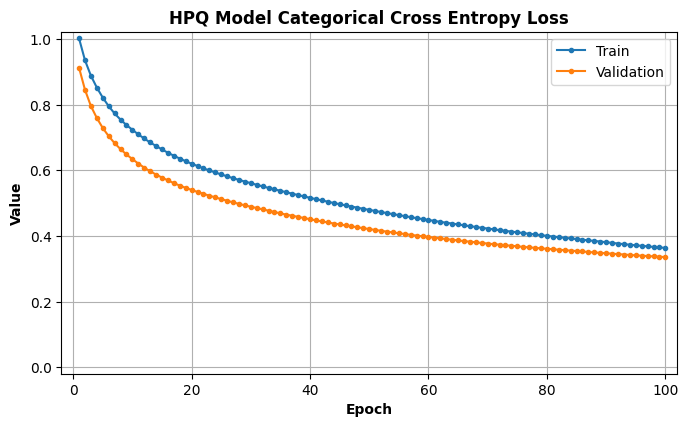

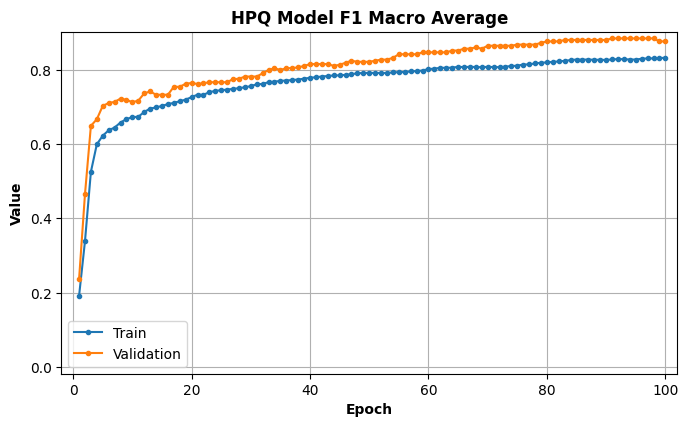

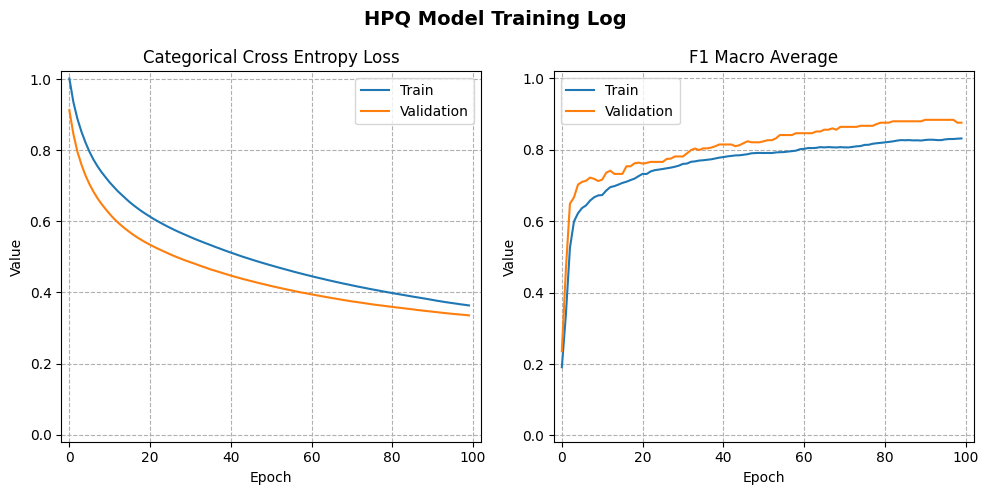

In [ ]:
plot_training_log(history['loss'], history['val_loss'], 'HPQ Model Categorical Cross Entropy Loss', 'loss_hpq')
plot_training_log(history['f1_macro'], history['val_f1_macro'], 'HPQ Model F1 Macro Average', 'f1_hpq')
dual_plot_training_log('HPQ Model Training Log', 'log_hpq',
                       history['loss'], history['val_loss'], 'Categorical Cross Entropy Loss',
                       history['f1_macro'], history['val_f1_macro'], 'F1 Macro Average')

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[[282  47   2]
 [ 20 279  32]
 [  7  56 268]]
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       331
           1       0.73      0.84      0.78       331
           2       0.89      0.81      0.85       331

    accuracy                           0.83       993
   macro avg       0.84      0.83      0.84       993
weighted avg       0.84      0.83      0.84       993



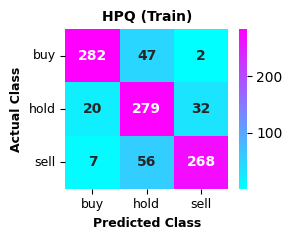

[[35  6  0]
 [ 1 39  2]
 [ 2  5 34]]
              precision    recall  f1-score   support

           0       0.92      0.85      0.89        41
           1       0.78      0.93      0.85        42
           2       0.94      0.83      0.88        41

    accuracy                           0.87       124
   macro avg       0.88      0.87      0.87       124
weighted avg       0.88      0.87      0.87       124



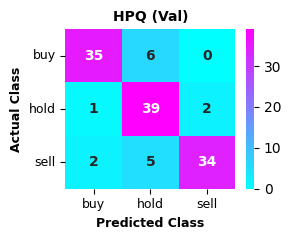

[[32 10  0]
 [ 1 38  2]
 [ 0  3 39]]
              precision    recall  f1-score   support

           0       0.97      0.76      0.85        42
           1       0.75      0.93      0.83        41
           2       0.95      0.93      0.94        42

    accuracy                           0.87       125
   macro avg       0.89      0.87      0.87       125
weighted avg       0.89      0.87      0.87       125



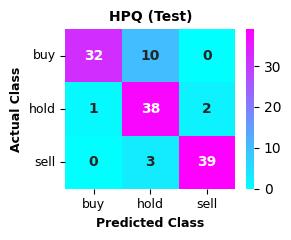

In [ ]:
y_train_pred_prob = model.predict(X_train, verbose=1)
y_train_pred = np.argmax(y_train_pred_prob, axis=1)
y_val_pred_prob = model.predict(X_val, verbose=1)
y_val_pred = np.argmax(y_val_pred_prob, axis=1)
y_test_pred_prob = model.predict(X_test, verbose=1)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)

cm_train = confusion_matrix(y_train, y_train_pred)
cm_val = confusion_matrix(y_val, y_val_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))
plot_confusion_matrix(cm_train, classes, 'HPQ (Train)', 'cm_hpq_train')
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))
plot_confusion_matrix(cm_val, classes, 'HPQ (Val)', 'cm_hpq_val')
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
plot_confusion_matrix(cm_test, classes, 'HPQ (Test)', 'cm_hpq_test')

In [ ]:
def format_num(pct, allvals):
    absolute = int(np.round(pct/100*np.sum(allvals)))
    return f"{absolute:d}\n({pct:.1f}%)"

def plot_triple_class_dist(df_dict, suptitle, filename):
    fig, axes = plt.subplots(1, 3, figsize=(3 * 3, 5.2), subplot_kw={'aspect': 'equal'})
    fig.suptitle(suptitle, fontweight='bold')

    for i, (model, df) in enumerate(df_dict.items()):
        ax = axes[i]

        data = df.values
        label = df.index

        wedges, texts, autotexts = ax.pie(
            x=data,
            autopct=lambda pct: format_num(pct, data),
            textprops={'color': 'black'},
            pctdistance=0.5,
        )
        ax.set_title(f'{model}')
        ax.legend(wedges, label, fontsize=9,
            loc='upper center',
            ncol=1,
            bbox_to_anchor=(0.5, 0.08, 0, 0)
        )
        plt.setp(autotexts, size=10, weight='normal')

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f'{filename}.png'))
    plt.show()

def plot_data_split(df, title, filename):
    data = df.values
    labels = df.index
    fig, ax = plt.subplots(figsize=(4, 4), subplot_kw={'aspect': 'equal'})
    wedges, texts, autotexts = ax.pie(
        x=data,
        autopct=lambda pct: format_num(pct, data),
        textprops={'color': 'black'},
        pctdistance=0.5,
    )
    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.legend(wedges, labels,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.2, 0, 0)
    )
    plt.setp(autotexts, size=10, weight='normal')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f'{filename}.png'))
    plt.show()

def plot_triple_data_split(df_list, suptitle, filename):
    n = len(df_list)
    fig, axes = plt.subplots(1, n, figsize=(3 * n, 4.2), subplot_kw={'aspect': 'equal'})
    fig.suptitle(suptitle, fontweight='bold')

    for i, (df, title) in enumerate(df_list):
        ax = axes[i]
        if df.empty:
            ax.set_title(title + "\n(No Data)")
            ax.axis('off')
            continue

        data = df.values
        label = df.index
        if np.sum(data) == 0:
            ax.set_title(title + "\n(No Data)")
            ax.axis('off')
            continue

        wedges, texts, autotexts = ax.pie(
            x=data,
            autopct=lambda pct: format_num(pct, data),
            textprops={'color': 'black'},
            pctdistance=0.5,
        )
        ax.set_title(title)
        ax.legend(wedges, label,
            loc='lower center',
            bbox_to_anchor=(0.5, -0.2, 0, 0)
        )
        plt.setp(autotexts, size=9, weight='normal')

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f'{filename}.png'))
    plt.show()

def plot_triple_model(arr_msft, arr_aapl, arr_hpq, title, filename):
    arr = np.concatenate((arr_msft, arr_aapl, arr_hpq))
    n = max(len(arr_msft), len(arr_aapl), len(arr_hpq))
    max_value = max(arr)
    plt.figure(figsize=(7, 4.375))
    plt.plot(range(1, len(arr_msft)+1), arr_msft, '.-', label='MSFT Model')
    plt.plot(range(1, len(arr_aapl)+1), arr_aapl, '.-', label='AAPL Model')
    plt.plot(range(1, len(arr_hpq)+1), arr_hpq, '.-', label='HPQ Model')
    plt.legend()
    plt.title(title, fontsize=12, fontweight='bold')
    plt.xlabel('Epoch', fontweight='bold')
    plt.ylabel('Value', fontweight='bold')
    plt.xlim([-0.02*n, 1.02*n])
    plt.ylim([-0.02*max_value, 1.02*max_value])
    plt.tight_layout()
    plt.grid()
    plt.savefig(os.path.join(OUTPUT_DIR, f'{filename}.png'))
    plt.show()

def dual_plot_triple_model(suptitle, filename,
                           train_arr_msft, train_arr_aapl, train_arr_hpq, title1,
                           val_arr_msft, val_arr_aapl, val_arr_hpq, title2):

    train_arr = np.concatenate((train_arr_msft, train_arr_aapl, train_arr_hpq))
    val_arr = np.concatenate((val_arr_msft, val_arr_aapl, val_arr_hpq))
    train_n = max(len(train_arr_msft), len(train_arr_aapl), len(train_arr_hpq))
    val_n = max(len(val_arr_msft), len(val_arr_aapl), len(val_arr_hpq))
    train_max_value = max(train_arr)
    val_max_value = max(val_arr)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax = ax.flatten()

    fig.suptitle(suptitle, fontweight='bold', fontsize=14)

    ax[0].plot(range(1, len(train_arr_msft)+1), train_arr_msft, label='MSFT Model')
    ax[0].plot(range(1, len(train_arr_aapl)+1), train_arr_aapl, label='AAPL Model')
    ax[0].plot(range(1, len(train_arr_hpq)+1), train_arr_hpq, label='HPQ Model')
    ax[0].legend()
    ax[0].set_title(title1, fontsize=12, fontweight='bold')
    ax[0].set_xlabel('Epoch', fontweight='bold')
    ax[0].set_ylabel('Value', fontweight='bold')
    ax[0].set_xlim([-0.02*train_n, 1.02*train_n])
    ax[0].set_ylim([-0.02*train_max_value, 1.02*train_max_value])
    ax[0].grid()

    ax[1].plot(range(1, len(val_arr_msft)+1), val_arr_msft, label='MSFT Model')
    ax[1].plot(range(1, len(val_arr_aapl)+1), val_arr_aapl, label='AAPL Model')
    ax[1].plot(range(1, len(val_arr_hpq)+1), val_arr_hpq, label='HPQ Model')
    ax[1].legend()
    ax[1].set_title(title2, fontsize=12, fontweight='bold')
    ax[1].set_xlabel('Epoch', fontweight='bold')
    ax[1].set_ylabel('Value', fontweight='bold')
    ax[1].set_xlim([-0.02*val_n, 1.02*val_n])
    ax[1].set_ylim([-0.02*val_max_value, 1.02*val_max_value])
    ax[1].grid()

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f'{filename}.png'))
    plt.show()

# Visualization

## Data Split & Class Distribution

In [ ]:
class_msft = pd.read_csv(os.path.join(LOG_DIR, 'class_dist_msft.csv'))
class_aapl = pd.read_csv(os.path.join(LOG_DIR, 'class_dist_aapl.csv'))
class_hpq = pd.read_csv(os.path.join(LOG_DIR, 'class_dist_hpq.csv'))

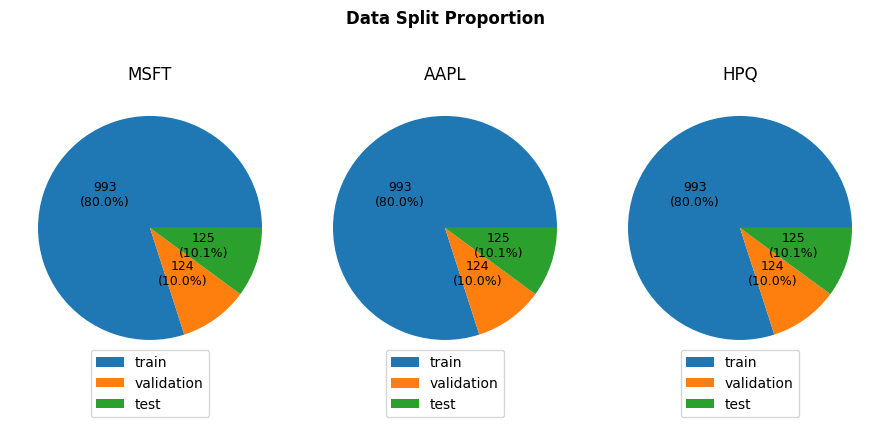

In [ ]:
order = ['train', 'validation', 'test']
dist_msft = class_msft.groupby('data_subset')['count'].sum().reindex(order)
dist_aapl = class_aapl.groupby('data_subset')['count'].sum().reindex(order)
dist_hpq = class_hpq.groupby('data_subset')['count'].sum().reindex(order)
title1 = 'MSFT'
title2 = 'AAPL'
title3 = 'HPQ'
suptitle = 'Data Split Proportion'
l = [(dist_msft, title1), (dist_aapl, title2), (dist_hpq, title3)]

plot_triple_data_split(l, suptitle=suptitle, filename='data_split_all')

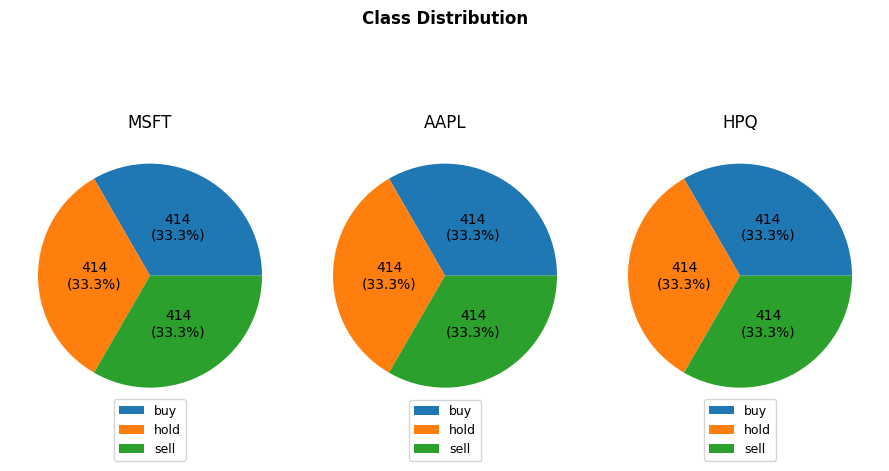

In [ ]:
order = ['train', 'validation', 'test']
dist_msft = class_msft.groupby(['class_name'])['count'].sum()
dist_aapl = class_aapl.groupby(['class_name'])['count'].sum()
dist_hpq = class_hpq.groupby(['class_name'])['count'].sum()
df_dict = {'MSFT': dist_msft, 'AAPL': dist_aapl, 'HPQ': dist_hpq}

plot_triple_class_dist(df_dict=df_dict, suptitle='Class Distribution', filename='class_dist_all')

## Training History

In [ ]:
log_msft = pd.read_csv(os.path.join(LOG_DIR, 'training_log_msft.csv'))
log_aapl = pd.read_csv(os.path.join(LOG_DIR, 'training_log_aapl.csv'))
log_hpq = pd.read_csv(os.path.join(LOG_DIR, 'training_log_hpq.csv'))
log_msft.tail(1)

,epoch,accuracy,auc,f1,f1_macro,f1_micro,f1_weighted,loss,precision,recall,val_accuracy,val_auc,val_f1,val_f1_macro,val_f1_micro,val_f1_weighted,val_loss,val_precision,val_recall
99,99,0.84995,0.967876,"""[tf.Tensor(0.90153843, shape=(), dtype=float3...",0.846129,0.845801,0.846129,0.338513,0.854938,0.836858,0.822581,0.961271,"""[tf.Tensor(0.8837209, shape=(), dtype=float32...",0.805685,0.818182,0.804564,0.362566,0.838983,0.798387


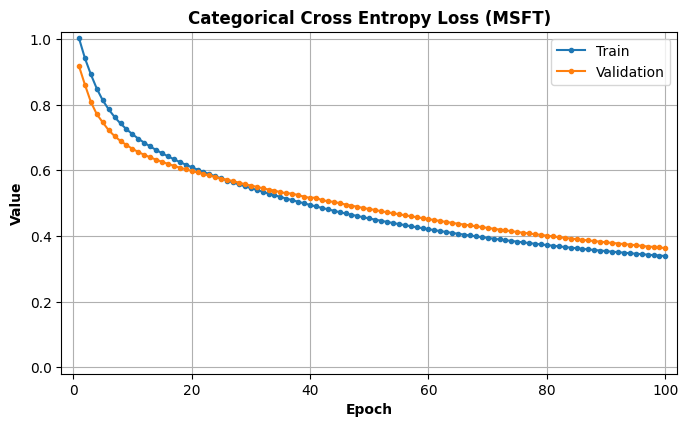

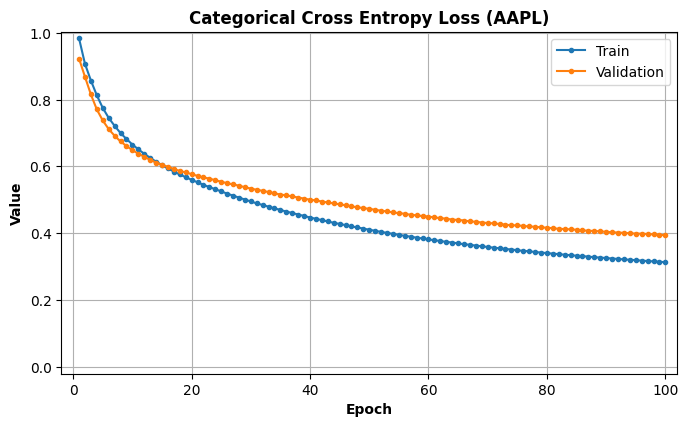

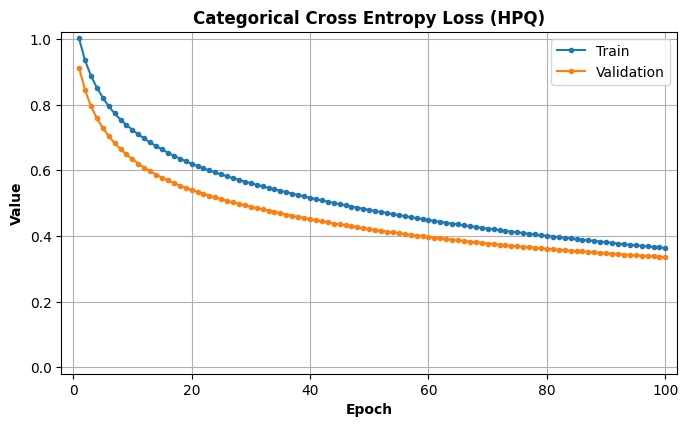

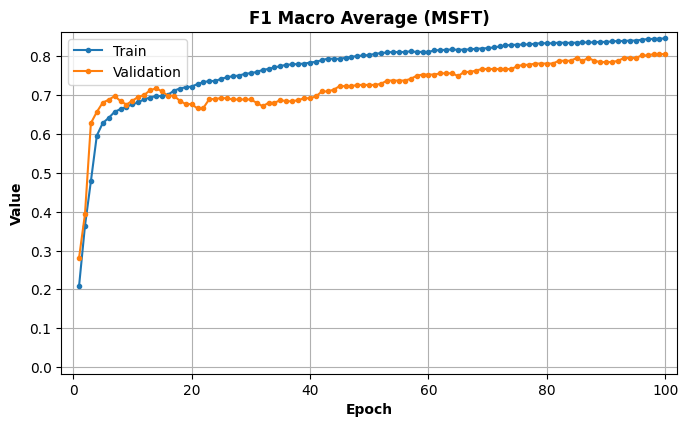

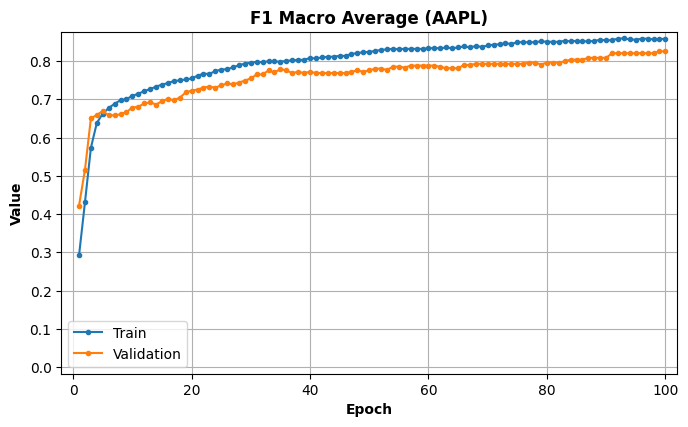

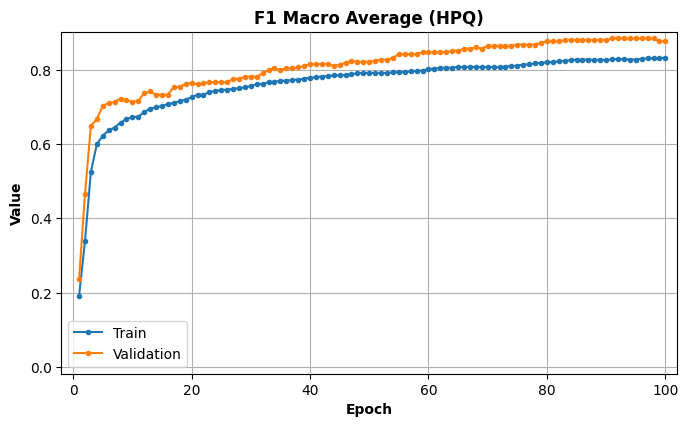

In [ ]:
plot_training_log(train_arr=log_msft['loss'], val_arr=log_msft['val_loss'], title='Categorical Cross Entropy Loss (MSFT)', filename='loss_msft')
plot_training_log(train_arr=log_aapl['loss'], val_arr=log_aapl['val_loss'], title='Categorical Cross Entropy Loss (AAPL)', filename='loss_aapl')
plot_training_log(train_arr=log_hpq['loss'], val_arr=log_hpq['val_loss'], title='Categorical Cross Entropy Loss (HPQ)', filename='loss_hpq')

plot_training_log(train_arr=log_msft['f1_macro'], val_arr=log_msft['val_f1_macro'], title='F1 Macro Average (MSFT)', filename='f1_msft')
plot_training_log(train_arr=log_aapl['f1_macro'], val_arr=log_aapl['val_f1_macro'], title='F1 Macro Average (AAPL)', filename='f1_aapl')
plot_training_log(train_arr=log_hpq['f1_macro'], val_arr=log_hpq['val_f1_macro'], title='F1 Macro Average (HPQ)', filename='f1_hpq')

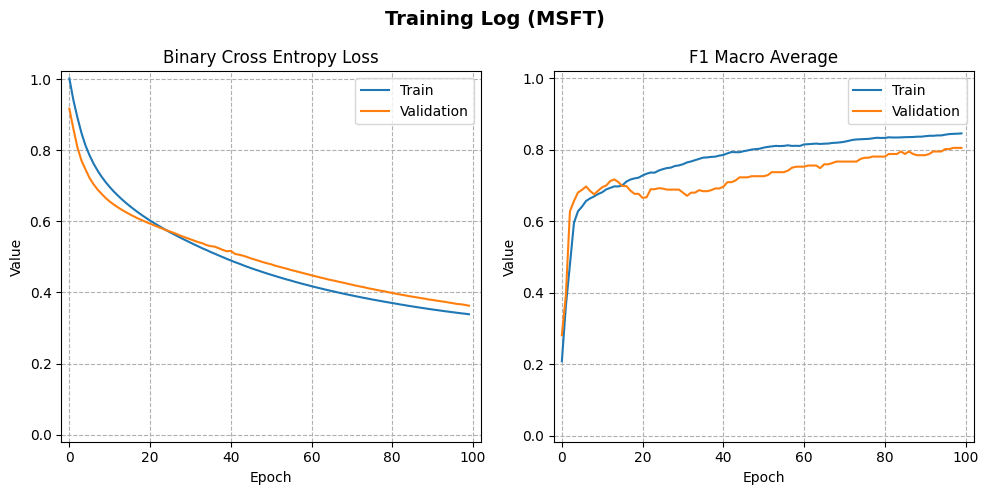

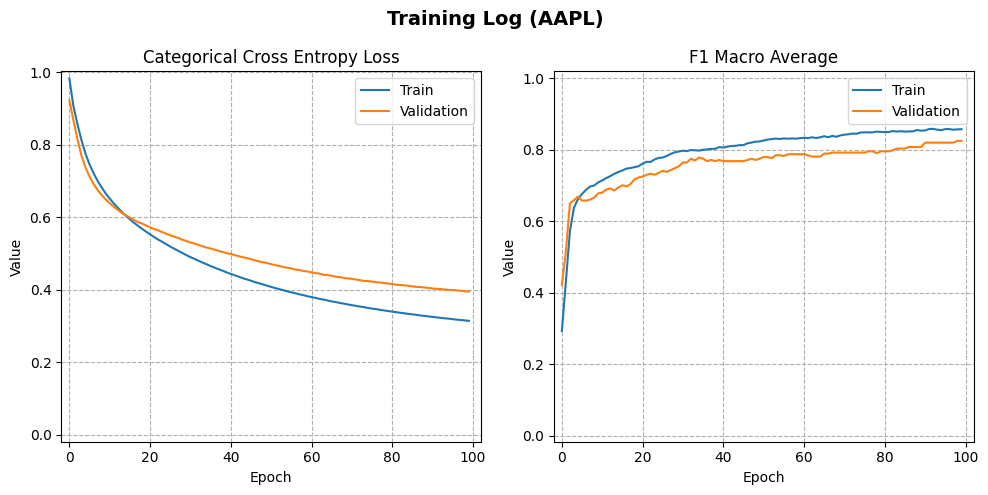

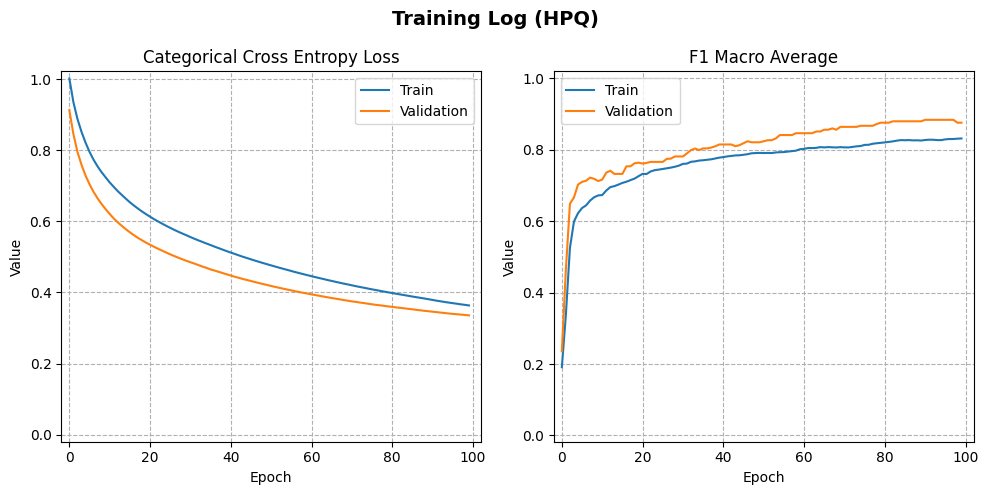

In [ ]:
dual_plot_training_log(suptitle='Training Log (MSFT)',
                       filename='log_msft',
                       train_arr1=log_msft['loss'], val_arr1=log_msft['val_loss'], title1='Binary Cross Entropy Loss',
                       train_arr2=log_msft['f1_macro'], val_arr2=log_msft['val_f1_macro'], title2='F1 Macro Average')
dual_plot_training_log(suptitle='Training Log (AAPL)',
                       filename='log_aapl',
                       train_arr1=log_aapl['loss'], val_arr1=log_aapl['val_loss'], title1='Categorical Cross Entropy Loss',
                       train_arr2=log_aapl['f1_macro'], val_arr2=log_aapl['val_f1_macro'], title2='F1 Macro Average')
dual_plot_training_log(suptitle='Training Log (HPQ)',
                       filename='log_hpq',
                       train_arr1=log_hpq['loss'], val_arr1=log_hpq['val_loss'], title1='Categorical Cross Entropy Loss',
                       train_arr2=log_hpq['f1_macro'], val_arr2=log_hpq['val_f1_macro'], title2='F1 Macro Average')

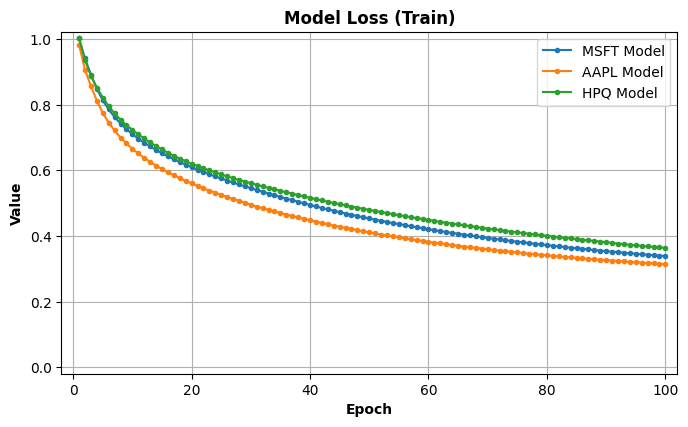

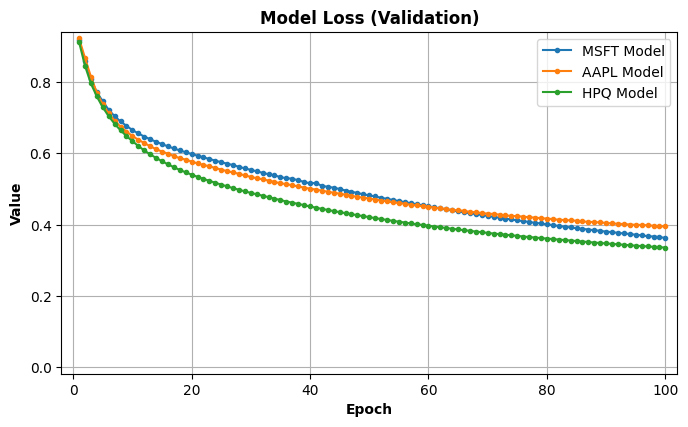

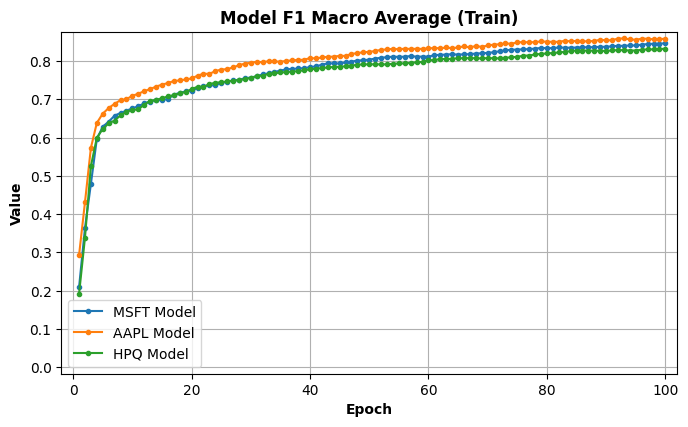

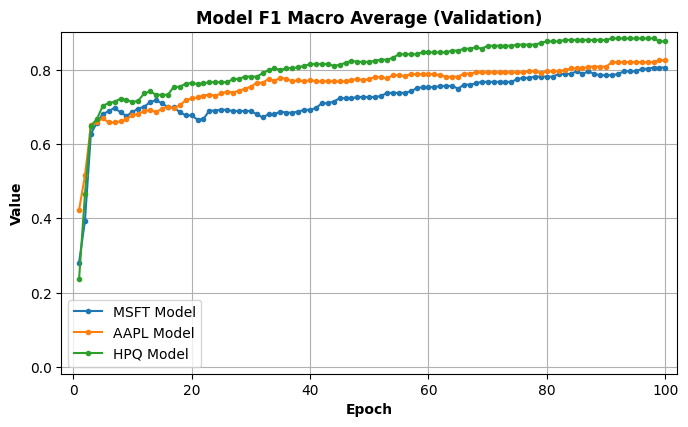

In [ ]:
# plot_triple_model(arr_binary=log_msft['learning_rate'],
#                   arr_quinary=log_aapl['learning_rate'],
#                   arr_main=log_main['learning_rate'],
#                   title='Model Learning Rate',
#                   filename='lr_all')
plot_triple_model(arr_msft=log_msft['loss'],
                  arr_aapl=log_aapl['loss'],
                  arr_hpq=log_hpq['loss'],
                  title='Model Loss (Train)',
                  filename='train_loss_all')
plot_triple_model(arr_msft=log_msft['val_loss'],
                  arr_aapl=log_aapl['val_loss'],
                  arr_hpq=log_hpq['val_loss'],
                  title='Model Loss (Validation)',
                  filename='val_loss_all')
plot_triple_model(arr_msft=log_msft['f1_macro'],
                  arr_aapl=log_aapl['f1_macro'],
                  arr_hpq=log_hpq['f1_macro'],
                  title='Model F1 Macro Average (Train)',
                  filename='train_f1_all')
plot_triple_model(arr_msft=log_msft['val_f1_macro'],
                  arr_aapl=log_aapl['val_f1_macro'],
                  arr_hpq=log_hpq['val_f1_macro'],
                  title='Model F1 Macro Average (Validation)',
                  filename='val_f1_all')

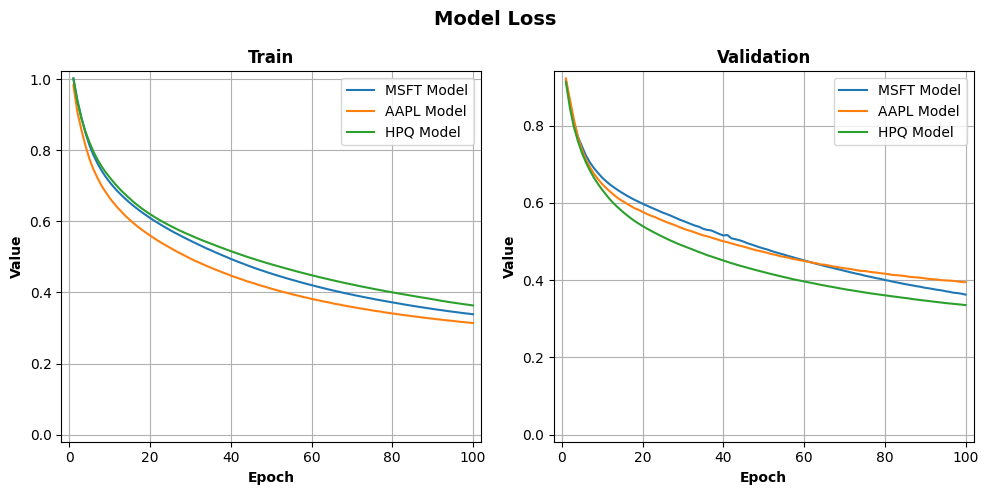

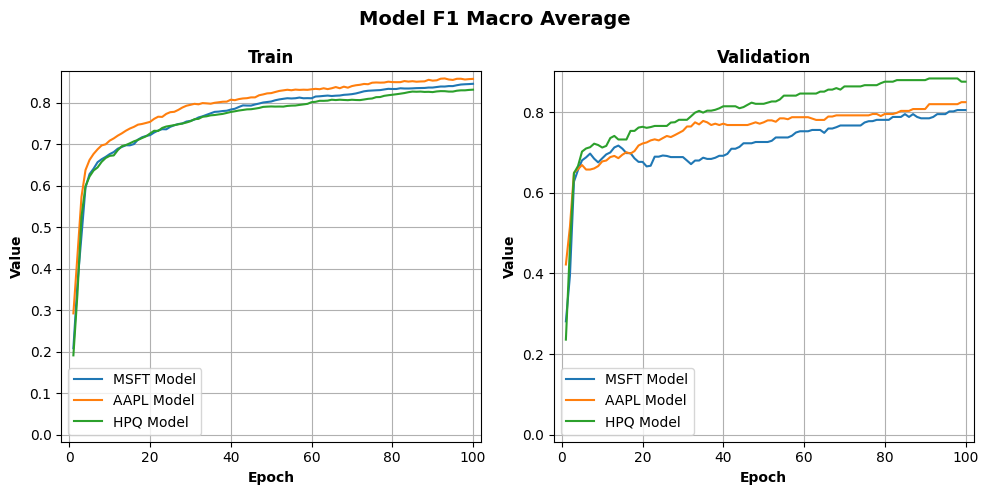

In [ ]:
dual_plot_triple_model(suptitle='Model Loss', filename='loss_all',
                       train_arr_msft=log_msft['loss'], train_arr_aapl=log_aapl['loss'], train_arr_hpq=log_hpq['loss'], title1='Train',
                       val_arr_msft=log_msft['val_loss'], val_arr_aapl=log_aapl['val_loss'], val_arr_hpq=log_hpq['val_loss'], title2='Validation')
dual_plot_triple_model(suptitle='Model F1 Macro Average', filename='f1_all',
                       train_arr_msft=log_msft['f1_macro'], train_arr_aapl=log_aapl['f1_macro'], train_arr_hpq=log_hpq['f1_macro'], title1='Train',
                       val_arr_msft=log_msft['val_f1_macro'], val_arr_aapl=log_aapl['val_f1_macro'], val_arr_hpq=log_hpq['val_f1_macro'], title2='Validation')

In [ ]:
!zip -r 'images.zip' '/content/images'
!zip -r 'logs.zip' '/content/logs'
!zip -r 'models.zip' '/content/models'

updating: content/images/ (stored 0%)
updating: content/images/f1_aapl.png (deflated 10%)
updating: content/images/train_loss_all.png (deflated 7%)
updating: content/images/f1_hpq.png (deflated 8%)
updating: content/images/data_split_all.png (deflated 9%)
updating: content/images/train_f1_all.png (deflated 7%)
updating: content/images/.zip (stored 0%)
updating: content/images/cm_msft_val.png (deflated 7%)
updating: content/images/loss_hpq.png (deflated 9%)
updating: content/images/loss_aapl.png (deflated 8%)
updating: content/images/log_hpq.png (deflated 10%)
updating: content/images/f1_msft.png (deflated 9%)
updating: content/images/cm_hpq_train.png (deflated 6%)
updating: content/images/val_f1_all.png (deflated 6%)
updating: content/images/cm_aapl_val.png (deflated 7%)
updating: content/images/log_aapl.png (deflated 10%)
updating: content/images/class_dist_all.png (deflated 12%)
updating: content/images/cm_hpq_val.png (deflated 6%)
updating: content/images/cm_msft_test.png (deflated 